<a href="https://colab.research.google.com/github/nataliasiennicka/cena_ubezpieczenia/blob/main/cena_ubezpieczenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importy

In [1]:
import numpy as np  #do obliczeń matematycznych i macierzowych
import pandas as pd  #do pracy na DataFrame
import seaborn as sns #do stworzenia wykresów
import matplotlib.pyplot as plt #do stworzenia wykresów
import plotly.graph_objs as go #konwecja graph objects -> go  - moduł 
from plotly.offline import iplot # do wykresów interaktywnych
from sklearn import tree #do wyplotowania wykresu drzewa decyzyjnego

#Tworzenie modeli
from sklearn.model_selection import train_test_split #do rozdzielania danych na zbiór testowy i treningowy
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów
from sklearn.tree import DecisionTreeRegressor #model drzewa decyzyjnego
from sklearn.linear_model import LinearRegression #model regresji liniowej
from sklearn.preprocessing import PolynomialFeatures #model wielomianu
from sklearn.preprocessing import StandardScaler #do standaryzacji danych
from sklearn.pipeline import make_pipeline #tworzenie przepływu danych i uczenia modelu na nich
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów

#Ocena modeli:
from sklearn.dummy import DummyRegressor #do porównania modeli
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from math import sqrt

#Funkcje

In [2]:
#FUNKCJA OCENY MODELI
def rate_the_model(y_train, y_train_dummy, y_train_predict, y_test, y_test_dummy, y_test_predict):
  
  #współczynnyk determinacji:
  print(f'Współczynnyk determinacji R^2 dla modelu Dummy: {r2_score(y_train,y_train_dummy)}')
  print(f'Współczynnyk determinacji R^2 dla modelu : {r2_score(y_train, y_train_predict)}')
  print()
  #MAE
  print(f'Na danych treningowych')
  print(f'MAE dla DummyModel: {mean_absolute_error(y_train,y_train_dummy)}')
  print(f'MAE dla modelu: {mean_absolute_error(y_train,y_train_predict)}')
  print()
  print(f'\nNa danych testowych:')
  print(f'MAE dla DummyModel: {mean_absolute_error(y_test,y_test_dummy)}')
  print(f'MAE dla modelu: {mean_absolute_error(y_test,y_test_predict)}')
  print()
  #MAPE
  print(f'\nNa danych treningowych:')
  print(f'MAPE dla DummyModel: {mean_absolute_percentage_error(y_train,y_train_dummy)*100}%')
  print(f'MAPE dla modelu: {mean_absolute_percentage_error(y_train,y_train_predict)*100}%')
  print()
  print(f'\nNa danych testowych:')
  print(f'MAPE dla DummyModel: {mean_absolute_percentage_error(y_test,y_test_dummy)*100}%')
  print(f'MAPE dla modelu: {mean_absolute_percentage_error(y_test,y_test_predict)*100}%')
  print()
  #MSE
  print(f'\nNa danych treningowych:')
  mse_dummy_train = mean_squared_error(y_train, y_train_dummy)
  mse_model_train = mean_squared_error(y_train, y_train_predict)
  print(f'\nTest:')
  print(f'MSE dla DummyModel: {mse_dummy_train}')
  print(f'MSE dla modelu: {mse_model_train}')
  print()
  print(f'\nNa danych testowych:')
  mse_dummy_test = mean_squared_error(y_test, y_test_dummy)
  mse_model_test = mean_squared_error(y_test, y_test_predict)
  print(f'\nTest:')
  print(f'MSE dla DummyModel: {mse_dummy_test}')
  print(f'MSE dla modelu: {mse_model_test}')
  print()
  #RMSE
  print(f'\nNa danych treningowych:')
  print(f'RMSE dla DummyModel: {sqrt(mse_dummy_train)}')
  print(f'RMSE dla modelu: {sqrt(mse_model_train)}')
  print()
  print(f'\nNa danych testowych:')
  print(f'RMSE dla DummyModel: {sqrt(mse_dummy_test)}')
  print(f'RMSE dla modelu: {sqrt(mse_model_test)}')


# Wczytanie danych

In [3]:
#pobranie tabeli z danymi z github
! git clone https://github.com/nataliasiennicka/cena_ubezpieczenia

Cloning into 'cena_ubezpieczenia'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 30 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [4]:
#wczytywanie danych w formie DATAFRAME
insurance = pd.read_csv('cena_ubezpieczenia/insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Problem do rozwiązania: jaki będzie koszt ubezpieczenia w zależności od określonych cech danej osoby? 

####Kategorie w posiadanej tabeli danych:
####**age** - wiek badanych osób
####**sex** - płeć (famale lub male)
####**bmi** - wskaźnik BMI inaczej wskaźnika masy ciała, obliczamy dzieląc masę ciała (w kilogramach) przez wzrost do kwadratu (w metrach). Wskaźnik ten wykorzystywany jest przede wszystkim do oceny ryzyka ryzyka pojawienia się groźnych chorób
####**children** - liczba dzieci, które posiada dana osoba
####**smoker**	 - czy osoba jest paląca czy nie (yes/no)
####**region** - region w którym mieszka osoba badna 
#### **charges** - kwota ubezpieczenia


## Wstępne rozpoznanie danych za pmocą PANDAS - PROFILING

In [5]:
#pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
#from pandas_profiling import ProfileReport
#profile =ProfileReport(insurance, title="Koszt ubezpieczenia")
#profile

W danych nie odnaleziono wartości brakujących.
Istnieją dwie wartości zduplikowane, jednak założono, że istnieje taka możliwość, że w przypadku obu obserwacji zanotowano te same cechy.

Na podstawie wstępnego przeglądania danych, można zaobserwować dużą zależność w wysokości ubezpieczenia od wieku oraz tego czy dana osoba jest paląca, bądź też nie.

Warto jednak przyjrzeć się danym dokładniej:

# Korelacja pomiędzy ziennymi numerycznymi

In [6]:
#Obliczenie koralacji dla cech, które posiadają wartości numeryczne
corr = insurance.corr()
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


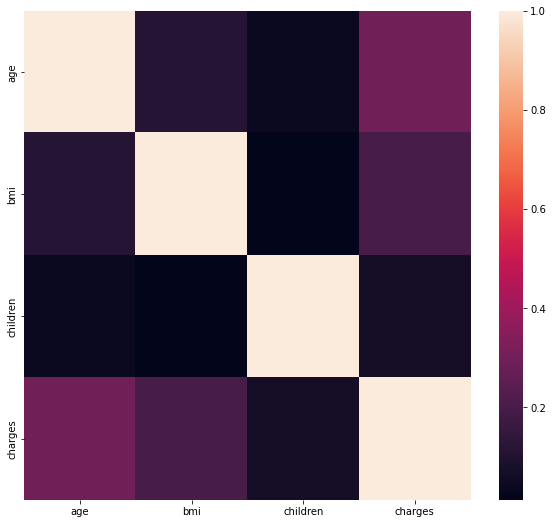

In [7]:
plt.figure(figsize=(10,9))
sns.heatmap(corr)
display()

Na podstawie Heat Map, można dostrzec, że analizując zmienne numeryczne, największy wpływ na koszt ubezpieczenia ma wiek, następnie wskaźnik BMI natomiast najmniejszy wpływ ma liczba posiadanych dzieci.

#Analiza cech

## Age

In [8]:
# określenie przedziału wieku badanych
print(f'Wiek badanych jest w przedziale:')
print(insurance['age'].min())
print (insurance['age'].max())

Wiek badanych jest w przedziale:
18
64


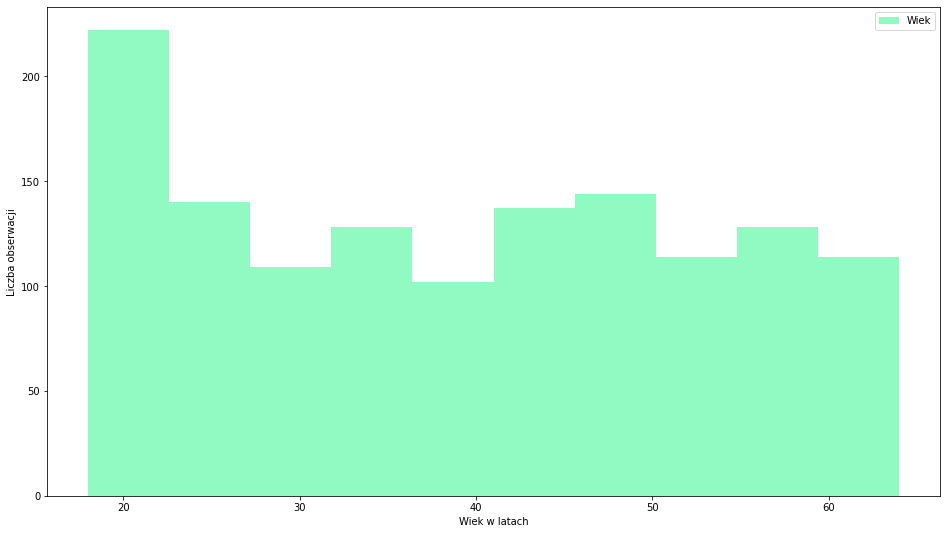

In [9]:
#Histogram przedstawiający rozkłąd wieku wśród obserwowanych osób
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(insurance['age'], 
        label="Wiek", 
        bins=10,
        color='#90FAC2')  

ax.legend()
ax.set_xlabel('Wiek w latach')
ax.set_ylabel('Liczba obserwacji')
plt.show()

Można dostrzec, że dużą grupę w osobach badanych stanowi grupa ludzi powiędzy 18, a 25 rokiem, żecia, jednak ilość osób w pozostałm wieku rozkłada się rónowiernie, więc stwierdzono, że dane w tej kategorii są reprezentatywne

In [10]:


trace1 = go.Scatter(
    x = insurance.age,
    y = insurance.charges,
    mode = 'markers',
    name = 'Kwota ubezpieczenia',
    marker = dict(color='rgba(0,255,200, 0.8)'),
    text = "wiek, kwota ubezpieczenia"
)



data = [trace1]
layout = dict(title = 'Zależność kwoty ubezpieczenia od wieku danej osoby',
xaxis = dict(title= 'Wiek w latach')
)
fig = dict(data = data, layout = layout)
iplot(fig)

Na podstawie powyższego wykresu można zaobserwować zależność wzrostu kwoty ubezpieczenia od wieku. Widać także, że kwoty te układają się w trzech oddzielnych pasach. Sugeruje to, że kwota ta, zależy od jeszcze conajmniej innego czynnika, dzięki któremu powsają obserwowane zależności.

## BMI:

Licznik BMI według podstawowej klasyfikacji wygląda następująco:

- niedowaga < 18,5

- wartość prawidłowa: (18,5-24,9)

- nadwaga: (25-29,9),

- otyłość ≥30 

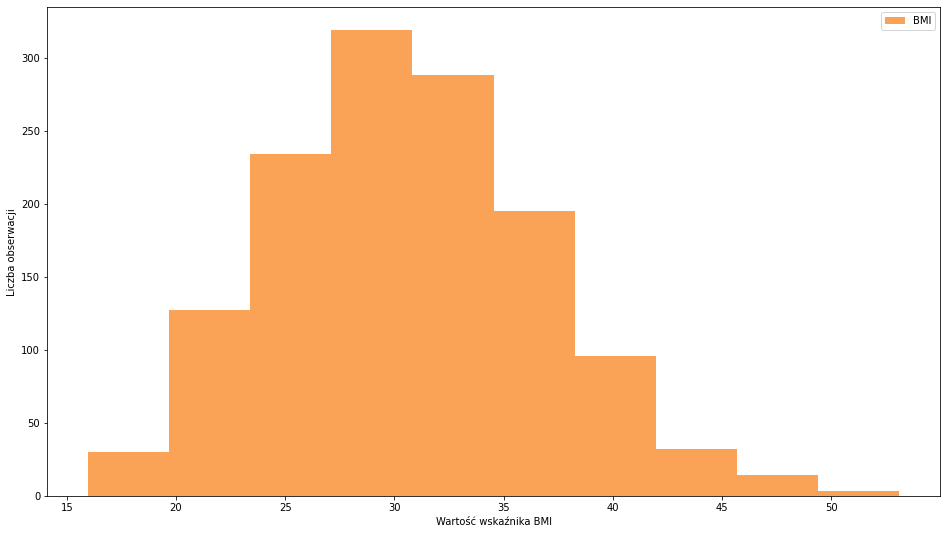

In [11]:
#Histogram przedstawiający rozkład wskażnika BMI wśród obserwowanych osób
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(insurance['bmi'], 
        label="BMI", 
        bins=10,
        color='#FAA255')  

ax.legend()
ax.set_xlabel('Wartość wskaźnika BMI')
ax.set_ylabel('Liczba obserwacji')
plt.show()

Można tu zaobserwować, że znaczna część osób odznacza się wskaźnikiem BMI, który sugeruje nadwagę, wśród badanej grupy

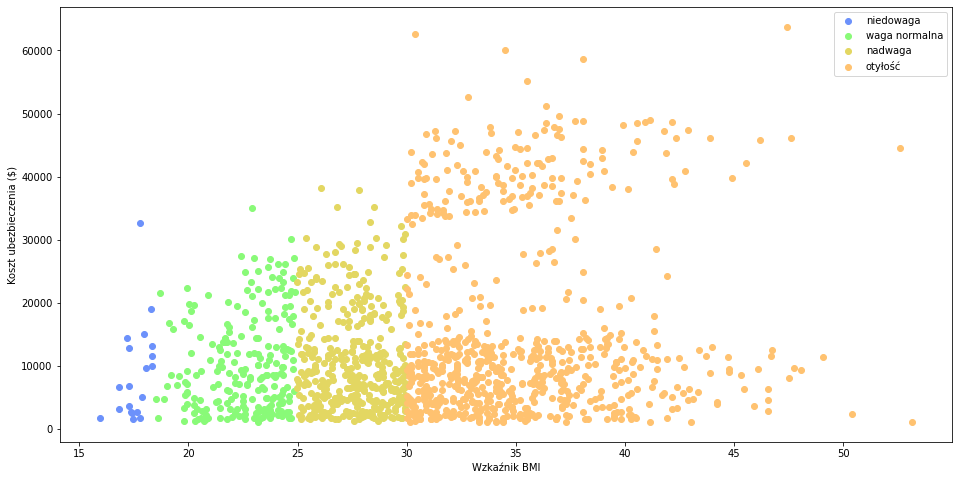

In [12]:
#Zdefiniowanie kategorii wagi, według wskaźnika BMI:
under_weight = insurance.loc[insurance['bmi']<18.5]
normal_weight = insurance.loc[(insurance['bmi']>=18.5)&(insurance['bmi']<24.9),:]
overweight = insurance.loc[(insurance['bmi']>=24.9)&(insurance['bmi']<30),:]
obesity= insurance.loc[insurance['bmi']>=30]

#Stworzenie wykresu zależności wagi od kosztu ubezpieczenia z oznaczeniem kolorem każdej z kategorii wynikającej z BMI
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(under_weight['bmi'], under_weight['charges'], color='#6C91FB', label='niedowaga')
ax.scatter(normal_weight['bmi'], normal_weight['charges'], color='#89FA78', label='waga normalna')
ax.scatter(overweight['bmi'], overweight['charges'], color='#E3D762', label='nadwaga')
ax.scatter(obesity['bmi'], obesity['charges'], color='#FFC270', label='otyłość')


ax.set_xlabel('Wzkaźnik BMI')
ax.set_ylabel('Koszt ubezbieczenia ($)')

ax.legend()
plt.show()

Dzięki prezentowanemu powyżej wykresowi, można zauważyć, że koszty ubezpieczenia rosną wzrast ze wzrostem wskaźnika BMI. Tak na przykład koszty ubezpieczenia dla ludzi znajdującej się w grupie osób otyłych, w skrajnych przypadkach są prawie dwa razy większe niż najbardziej kosztowne ubezpieczenie wśród osób o wadze normalnej.

## Sex

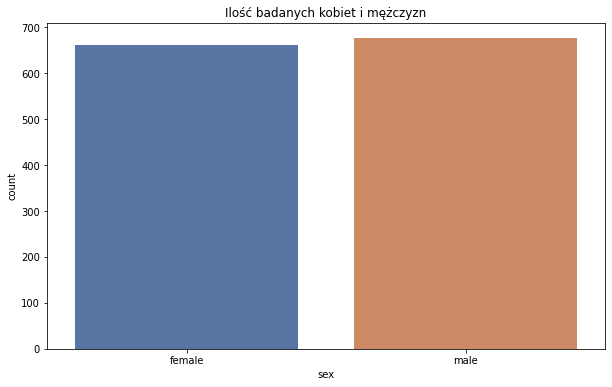

In [13]:
#Stworzenie wykresów słupkowych prezentujących liczbę przebadanych kobiet i mężczyzn
plt.figure(figsize=(10,6))
sns.countplot(data=insurance, 
              x='sex',
              palette = "deep")
plt.title('Ilość badanych kobiet i mężczyzn')
plt.show()

Możemy zaobserwować, że ilość badanych kobiet oraz mężczyzn jest bardzo zbliżona, dzięki temu możemy usnać, że dane są reprezentatywne, ponieważ obserwacje po równo rozkładają się dla każdej z płci.

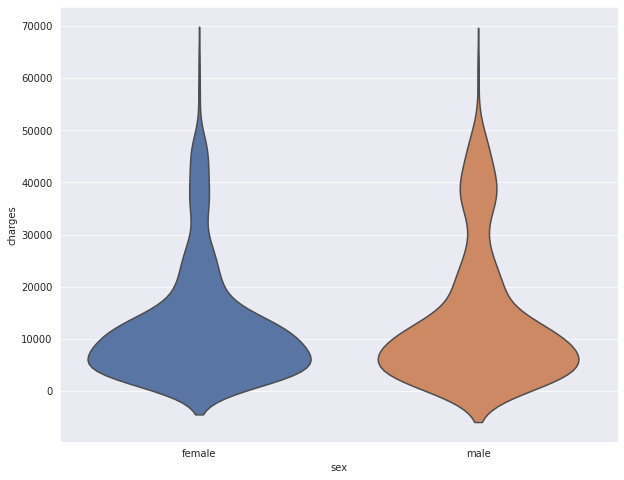

In [14]:
#Stworzenie wykresu skrzypcowego dla kategorii 'sex'
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, x='sex', y='charges',
               inner=None,
               palette = "deep")

Na powyższym wykresie widać także, że koszt upezbieczenia rozkłada się bardzo podobnie dla obu płci. 

Zdecydowano się nie używać tej kategorii w tworzeniu modeli, ponieważ jej wpływ na koszt jest znikomy oraz płeć nie powinna mieć wpływu na koszty związane z leczeniem. Gdyby w tym problemi wzięto ją pod uwagę wystąpiłby problem z uprzedzeniami, którego należy unikać podczas opracowania modelu.

## Children

In [15]:
print(f'Największa liczba dzieci jaką posiada badana osoba to: {insurance["children"].max()}')

Największa liczba dzieci jaką posiada badana osoba to: 5


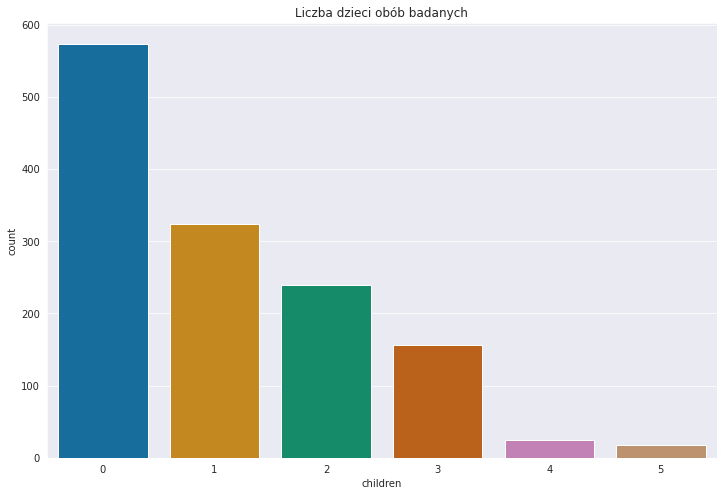

In [16]:
# Wykres obrazujący posiadną liczbę dzieci przez osoby badane
plt.figure(figsize=(12,8))
sns.countplot(data=insurance, 
              x='children',
              palette = "colorblind")
plt.title('Liczba dzieci obób badanych')
plt.show()

W przebadanej grupie najwięcej osób było bezdzietnych. Niewielką grupę stanowią także osoby, które mają 4 lub 5 dzieci.

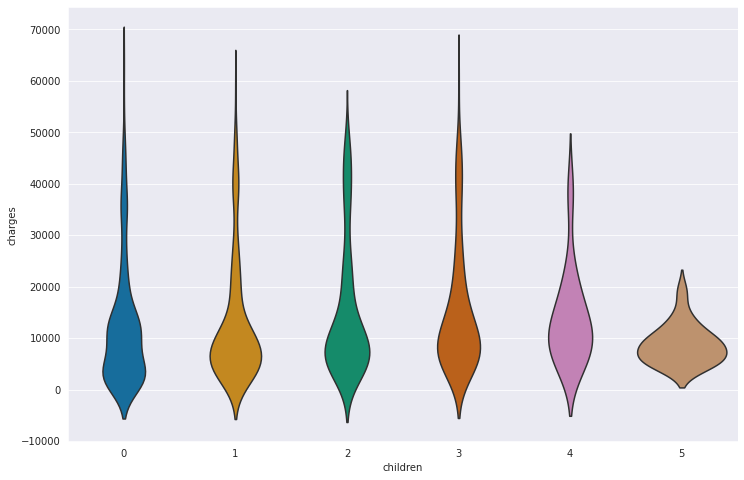

In [17]:
#Stworzenie wykresu skrzypcowego dla kategorii 'children'
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, 
               x='children', 
               y='charges',
               palette = "colorblind",
               inner=None)
plt.show()

Analizując wykres skrzypcowy można dostrzec, że koszty ubezpieczenie rozkładają się bardzo podobnie w grupach od 0 do 4 dzieci, natomiast osoby posiadające 5 dzieci zdecydowanie częściej ponoszą bardzo podobne koszty zbliżone do średniej w tej grupi osób. Istnieje też znaczna różnica pomiędzy rozpiętością kosztów pomiędzy tą grupą a pozostałymi. Stąd można wywnioskować, że ilość posiadanych dzieci przy ich liczbie większej od 4 może wpływać na koszty ubezpieczenia.

##Smoker

In [18]:
print( f'Liczba wszystkich obserwacji to : {len(insurance.index)}')

Liczba wszystkich obserwacji to : 1338


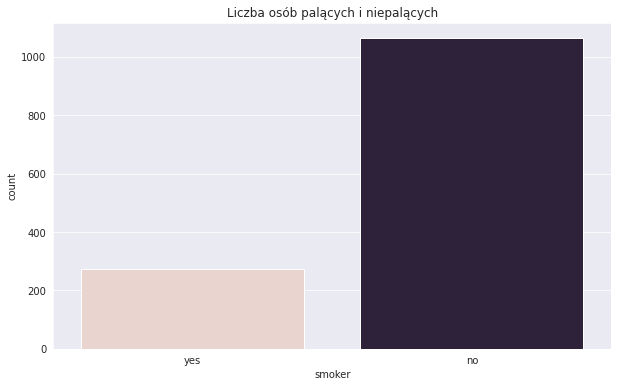

In [19]:
#Wykres reprezentujący liczbę osób palących i niepalących

plt.figure(figsize=(10,6))
sns.countplot(data=insurance, 
              x='smoker',
              palette = "ch:")
plt.title('Liczba osób palących i niepalących')
plt.show()

W badaniu wzięło udział znacznie wiecej palących niż niepalących, jednak dane są reprezentatywne ponieważ w grupie 1338 obserwacji ponad 200 stanowią osoby niepalące

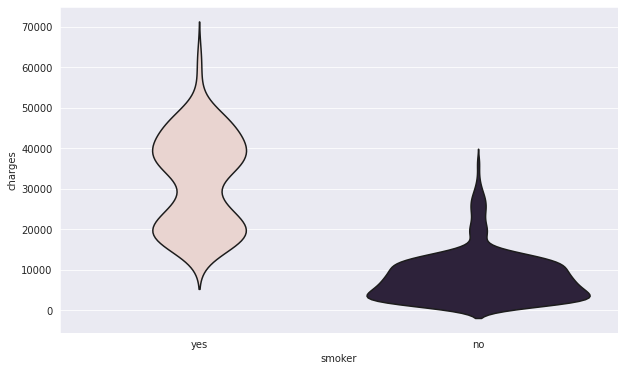

In [20]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, 
               x='smoker', 
               y='charges',
               palette = "ch:",
               inner=None)
plt.show()

Kategoria palący/niepalący ma znaczący wpływ na zmienną 'charges' co widać na powyższym wykresie. Osoby palące ponoszą zwykle wyższe koszta związane z opłaceniem ubezpieczenia. Można również zaobserwować, że duża część osób niepalących płaci dość niski koszt ubezpieczenia (wykres skrzypcowy jest znacznie bardziej 'rozlany' u podstawy co oznacza, że w tej grupie opłaty większości osób są bliżej dolnej granicy rozpiętości stawek dla tej grupy) W grupie osób palących minimalna oraz maksymalna kwota ubezpieczenia jest róznież o wiele wyższa.

##Region

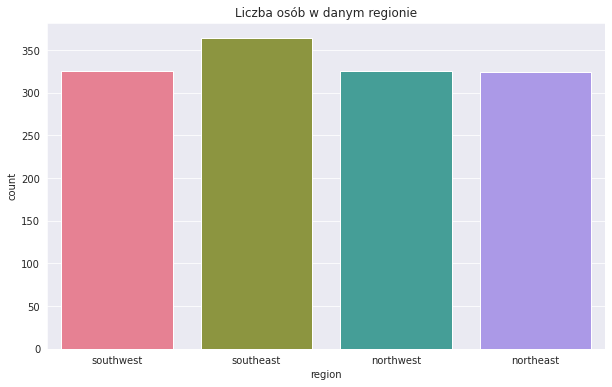

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(data=insurance, 
              x='region',
              palette = "husl")
plt.title('Liczba osób w danym regionie')
plt.show()

Liczebność osób w kązdym z regionów jest podobna. Dane są reprezentatywne.

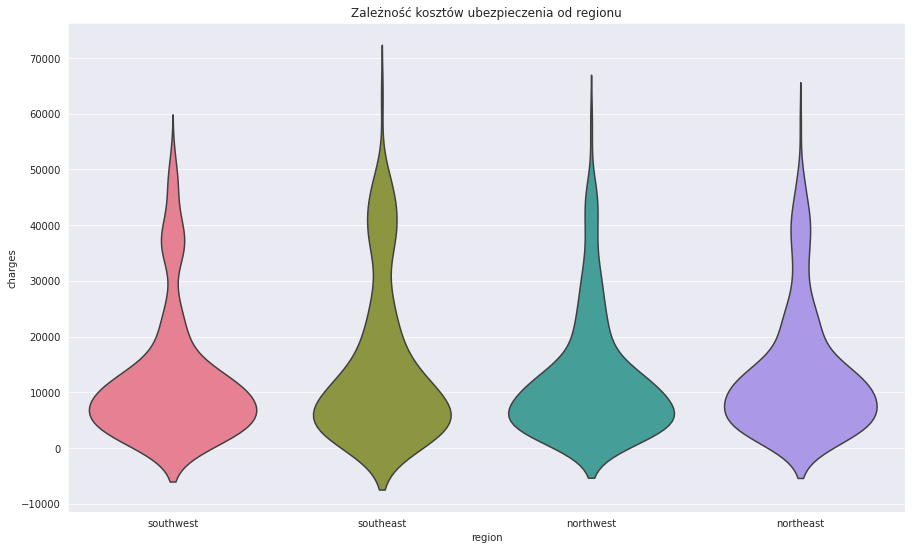

In [22]:
plt.figure(figsize=(15,9))
sns.set_style('darkgrid')
sns.violinplot(data=insurance, 
               x='region', 
               y='charges',
               palette = "husl",
               inner=None)
plt.title('Zależność kosztów ubezpieczenia od regionu')
plt.show()

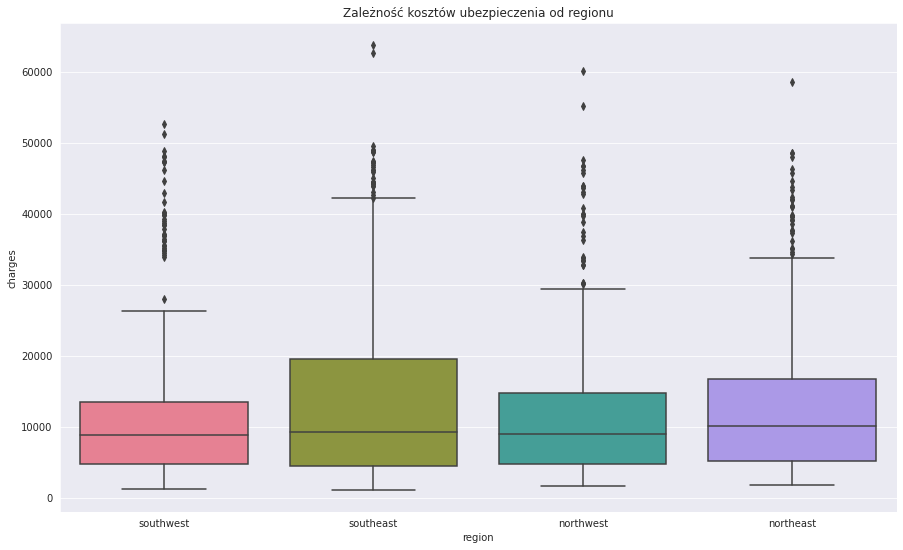

In [23]:
plt.figure(figsize=(15,9))
sns.boxplot(data=insurance, 
            x='region', 
            y='charges',
            palette = "husl")
plt.title('Zależność kosztów ubezpieczenia od regionu')
plt.show()

Analizując powyższe dwa wykresy można stwierdzić, że koszty ubezpieczenia rozkładają się bardzo podobnie w każdej z dzielnic. Wyraźnie widać też, że średnie są bardzo podobne, co sygnalizuje, iż wpły pochodzenia osoby badanej może mieć niewielki wpływ na kategorię 'charges'

# Podział zamiennych na kategoryczne i numeryczne

Na podstawie wykresów widzimy, że na kwotę ubezpieczenie wpływa wiek, BMI oraz to czy osoba jest paląca, niewielki wpływ ma natomiast posiadana przez się liczba dzieci oraz region z którego pochodzi. Nie zobserwowano wpływu na kwotę ubezpieczenia od płci.

Kategorię płeć usuwamy, ponieważ w tym zagadnieniu nie ma on wpływu. Poza tym dana płeć nie może być wykorzystywana do oceny (uprzedzenia).
Postanowiono różnież usunąć kategorię regionu pochodzenia, ponieważ ma znikomy wpływ.

In [24]:
#Podział na dane numeryczne i kategoryczne
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker']
target = 'charges'

In [25]:
#Stworzenie nowej tabeli stanowiącej podstawę do tworzenia modeli

smoker = pd.get_dummies(insurance['smoker'], drop_first=True) #zamiana kategorii na 0/1

insurance_new = insurance.copy() #skopiowanie danych ddo nowej tabeli
insurance_new = insurance_new.drop(columns={'sex','region','smoker'}) #usunięcie z nowej tabeli kategorii, które nie będą podlegały ocenie
insurance_new=pd.concat([insurance_new,smoker],axis=1) #złączenie tabeli z nową tabelą skoker
insurance_new = insurance_new.rename(columns={'yes':'smoker'}) #zmiana nazwy kolumny
insurance_new

,age,bmi,children,charges,smoker
0,19,27.900,0,16884.92400,1
1,18,33.770,1,1725.55230,0
2,28,33.000,3,4449.46200,0
3,33,22.705,0,21984.47061,0
4,32,28.880,0,3866.85520,0
...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0
1334,18,31.920,0,2205.98080,0
1335,18,36.850,0,1629.83350,0
1336,21,25.800,0,2007.94500,0


Parametry opisujące nową tabelę:

smoker: 1 - palący 2 - niepalący

In [26]:
# podstawowe wartości opisujące tabelę służącą do modelu
insurance_new.describe()

,age,bmi,children,charges,smoker
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.204783
std,14.049960,6.098187,1.205493,12110.011237,0.403694
min,18.000000,15.960000,0.000000,1121.873900,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000
50%,39.000000,30.400000,1.000000,9382.033000,0.000000
75%,51.000000,34.693750,2.000000,16639.912515,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000


# Tworzenie modelu na podstawie jednej zmiennej

W pierwszym podejściu analizowane będzie to jak skuteczne będą modele regresji liniowej wielomianowej oraz drzewa decyzyjnego trenowane na podstawie tylko jednej zmiennej, dla której zaobserwowano koralację pomiędzy jej zmianą z kosztem ubezpieczenia.

Zmienna przyjęta do analizy to 'age'.

In [27]:
#Określenie zbiorów danych X i y, które posłużą w dalszej analizie
X = insurance_new[['age']]
y= insurance_new['charges']

# Podział zbioru na testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

##Dummy model

Stworzono model do którego będzie można porównywać wszystkie oceny dla zbioru danych wykorzysujących jedną zmienną do analizy

In [28]:
# Stworzenie modelu, do którego możena porównać nowo stworzone modele
dummy_model = DummyRegressor(strategy='mean') # użycie dummymodel jako model porównawczy
dummy_model.fit(X_train, y_train) #trenowanie
y_train_dummy = dummy_model.predict(X_train) #przewidywany y_dummy na zbiorze treningowym
y_test_dummy  = dummy_model.predict(X_test) #przewidywany y_dummy na zbiorze testowym

## Model drzewa decyzyjnego

In [29]:
# stworzenie modelu drzewa decyzyjnego
tree_model_one = DecisionTreeRegressor()

# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

#Stworzenie GridSearch'a, który wyszuka najlepszych parametrów, jednocześnie tworząc zbiór welidacyjny za pomocą kroswalidacji
tree_regression_gridsearch_one = GridSearchCV(tree_model_one, 
                                                params, #parametry do sprawdzenia
                                                scoring='neg_mean_squared_error',
                                                cv=10, #cross walidacja
                                                verbose=10) #verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model

#trenowanie modelu na tym z najlepszymi parametrami
tree_regression_gridsearch_one.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_regression_gridsearch_one.best_params_)

tree_regression_model_one = tree_regression_gridsearch_one.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-190484596.778 total time=   0.0s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-130014076.455 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-129780765.569 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-107909116.637 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-142791166.150 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1.........

Najlepszymi parametrami dla drzewa decyzyjnego są:

'max_depth': 2, 

'min_samples_leaf': 1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names



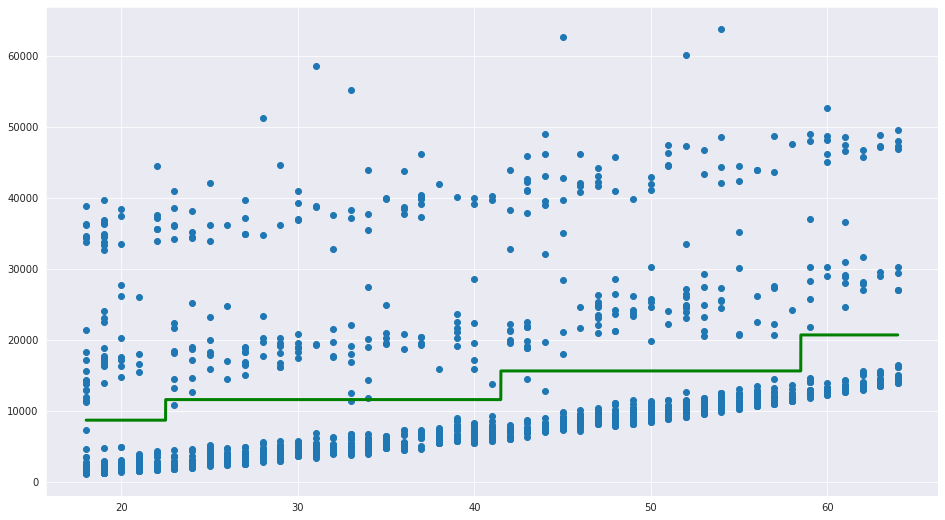

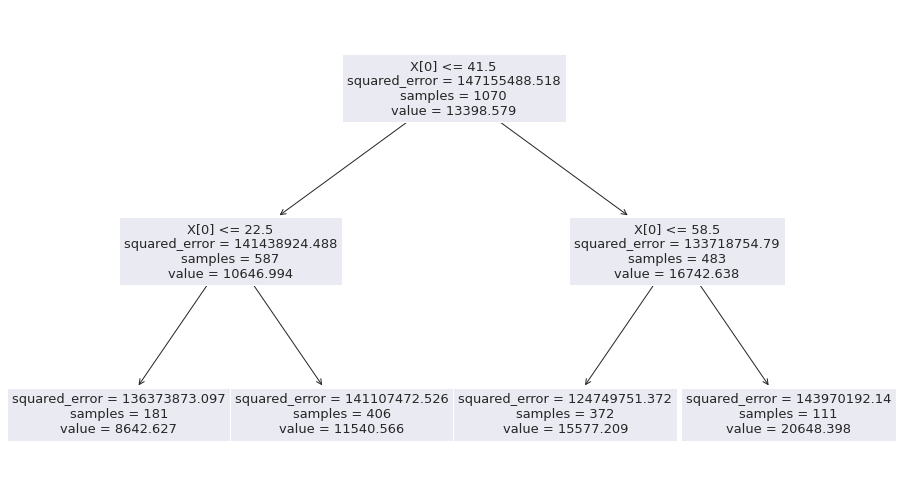

In [30]:
# stworzenie linii podziału na kolejne przedziały
X_linespace_one = np.arange(X.min()[0],X.max()[0], step=0.001).reshape(-1,1)

#Stworzenie zbioru y przewidywanych według modelu
y_fitted_tree_one = tree_regression_model_one.predict(X_linespace_one)

#Stworzenie wykresu punktowego
plt.figure(figsize=(16,9))
plt.scatter(X, y)
plt.plot(X_linespace_one, y_fitted_tree_one, linewidth=3, color='green')
plt.show()
    
plt.figure(figsize=(16,9))
tree.plot_tree(tree_regression_model_one)
plt.show()

Powyższe dwa wykresy, prezentują, że model dzieli dane na 4 przedziały i w każdym z nich wyznacza wartość średnią, która staje się przewidywaną wartością y, co możemy zobserwować na poniżej stworzonym wykresie:

In [31]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_model_tree = tree_regression_model_one.predict(X_train)
y_predict_test_model_tree = tree_regression_model_one.predict(X_test)

Jak widać wartości przwidywane znacznie odbiegają od rzeczywistych, co szczególnie można zauwaćyć na wykresie dla zbioru testowego

### Ocena modelu drzewa decyzyjnego dla jednej zmiennej

In [32]:
rate_the_model(y_train, y_train_dummy, y_predict_train_model_tree, y_test, y_test_dummy, y_predict_test_model_tree)

Współczynnyk determinacji R^2 dla modelu Dummy: 0.0
Współczynnyk determinacji R^2 dla modelu : 0.08316887258887151

Na danych treningowych
MAE dla DummyModel: 9172.631949962091
MAE dla modelu: 9100.967030501119


Na danych testowych:
MAE dla DummyModel: 9004.29746646955
MAE dla modelu: 8727.313881117267


Na danych treningowych:
MAPE dla DummyModel: 151.82519574175143%
MAPE dla modelu: 120.29928861656552%


Na danych testowych:
MAPE dla DummyModel: 160.6775952090012%
MAPE dla modelu: 126.12617705819275%


Na danych treningowych:

Test:
MSE dla DummyModel: 147155488.51841778
MSE dla modelu: 134916732.44307637


Na danych testowych:

Test:
MSE dla DummyModel: 144178448.72444746
MSE dla modelu: 123322253.14684914


Na danych treningowych:
RMSE dla DummyModel: 12130.766196676028
RMSE dla modelu: 11615.366220790302


Na danych testowych:
RMSE dla DummyModel: 12007.433061418558
RMSE dla modelu: 11105.055296883898


## Model regresji wielomianowej

In [33]:
polynomial_regression_pipeline = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression()) #pipeline tworzacy model rekresji wielomianu
# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6]}

polynomial_regression_gridsearch = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch.best_params_)

polynomial_regression_model = polynomial_regression_gridsearch.best_estimator_

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 1/10; 1/6] END polynomialfeatures__degree=1;, score=-193191016.709 total time=   0.0s
[CV 2/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 2/10; 1/6] END polynomialfeatures__degree=1;, score=-126141609.766 total time=   0.0s
[CV 3/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 3/10; 1/6] END polynomialfeatures__degree=1;, score=-130634677.772 total time=   0.0s
[CV 4/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 4/10; 1/6] END polynomialfeatures__degree=1;, score=-101562730.700 total time=   0.0s
[CV 5/10; 1/6] START polynomialfeatures__degree=1...............................
[CV 5/10; 1/6] END polynomialfeatures__degree=1;, score=-140170985.590 total time=   0.0s
[CV 6/10; 1/6] START polynomialfeatures__degree=1...............................
[CV

Najlepsze parametry:

wielomian stopnia: 2

In [34]:
# Stworzenie y przewidywanego
y_predict_train_polynomial_regression = polynomial_regression_model.predict(X_train)
y_predict_test_polynomial_regression = polynomial_regression_model.predict(X_test)

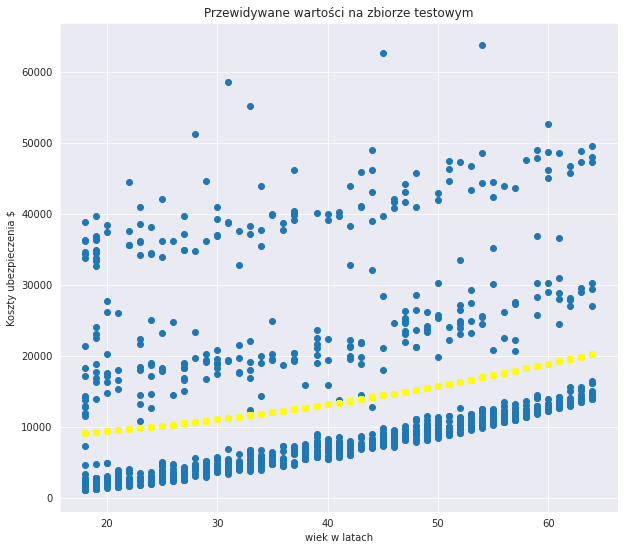

In [35]:
plt.figure(figsize=(10,9))
plt.scatter(X_train, y_train)
plt.scatter(X_train, y_predict_train_polynomial_regression, color='yellow')
plt.xlabel('wiek w latach')
plt.ylabel('Koszty ubezpieczenia $')
plt.title('Przewidywane wartości na zbiorze testowym')
plt.show()

Na podstawie powyższego wykresu dla danych przewidywanych na podstawie stworzonego modelu, można dostrzec, że wartości prawdziwe znacznie odbiegają od predykcji.

### Ocena modelu regresji dla jednej zmiennej

In [36]:
rate_the_model(y_train, y_train_dummy, y_predict_train_polynomial_regression, y_test, y_test_dummy, y_predict_test_polynomial_regression)

Współczynnyk determinacji R^2 dla modelu Dummy: 0.0
Współczynnyk determinacji R^2 dla modelu : 0.0760296179539326

Na danych treningowych
MAE dla DummyModel: 9172.631949962091
MAE dla modelu: 9199.090412957323


Na danych testowych:
MAE dla DummyModel: 9004.29746646955
MAE dla modelu: 8781.583709931885


Na danych treningowych:
MAPE dla DummyModel: 151.82519574175143%
MAPE dla modelu: 121.51441876148145%


Na danych testowych:
MAPE dla DummyModel: 160.6775952090012%
MAPE dla modelu: 126.66877932250055%


Na danych treningowych:

Test:
MSE dla DummyModel: 147155488.51841778
MSE dla modelu: 135967312.94653818


Na danych testowych:

Test:
MSE dla DummyModel: 144178448.72444746
MSE dla modelu: 123080851.79952022


Na danych treningowych:
RMSE dla DummyModel: 12130.766196676028
RMSE dla modelu: 11660.502259617215


Na danych testowych:
RMSE dla DummyModel: 12007.433061418558
RMSE dla modelu: 11094.180988226226


# Tworzenie modelu na podstawie wielu zmiennych

Powyższe przewidywania na podstawie jednej zmiennej zdecydowanie nie dały dobrych wyników, dlatego wprowadzono pozostałe cechy, które mają wpływ na koszty ubezpieczenia. 

Poniżej pogrupowano je na zmienne numeryczne oraz kategoryczne.

In [37]:
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['smoker','region']
targer = 'charges'

In [38]:
#Określenie zbiorów danych X i y, które posłużą w dalszej analizie
X = insurance_new.drop([target], axis=1) #zbiór X to wszystkie kolumny oprócz naszej szukanej
y = insurance_new[target] # zbiór szukany

# Podział zbioru na testowy i treningowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

## Dummy Model

In [39]:
# Stworzenie modelu, do którego możena porównać modele o nowym zbiorze wielu zmiennych
dummy_model_v2 = DummyRegressor(strategy='mean') 
dummy_model_v2.fit(X_train, y_train) 
y_train_dummy_v2 = dummy_model_v2.predict(X_train) #przewidywany y_dummy na zbiorze treningowym
y_test_dummy_v2  = dummy_model_v2.predict(X_test) #przewidywany y_dummy na zbiorze testowym

##Model drzewa decyzyjnego

In [40]:
tree_model_many = DecisionTreeRegressor()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

tree_regression_gridsearch_many = GridSearchCV(tree_model_many, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_regression_gridsearch_many.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_regression_gridsearch_many.best_params_)

tree_regression_model_many = tree_regression_gridsearch_many.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-72993467.989 total time=   0.3s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-55412238.175 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-59358510.916 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-51244070.630 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=-64440320.672 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1..............

Najlepszymi parametrami dla drzewa decyzyjnego są:
'max_depth': 5 ,
'min_samples_leaf': 10

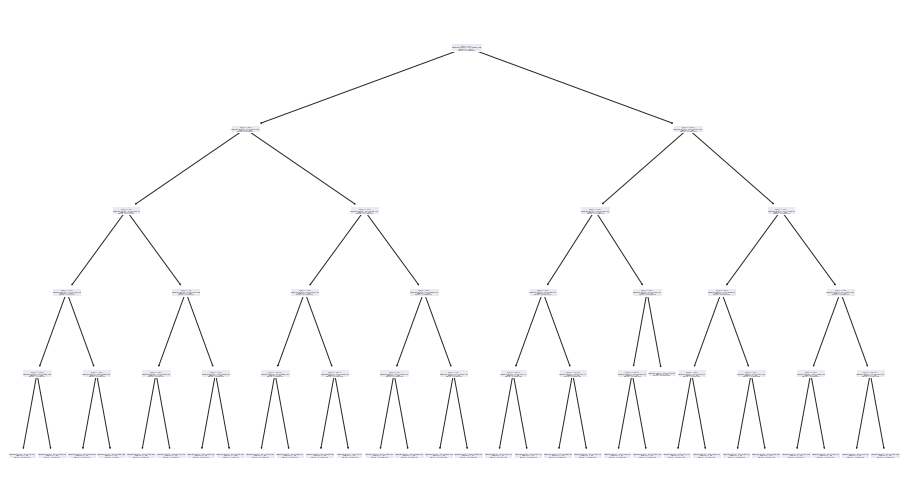

In [41]:
# wykres przedstawiający kolejne kroki drzewa decyzyjnego    
plt.figure(figsize=(16,9))
tree.plot_tree(tree_regression_model_many)
plt.show()

Na powyższym wykresie można zaobserwować, że dane zostały podzielone na wiele więcej przedziałów.

In [42]:
# Przewidywany y na zbiorze treningowym i testowym
y_predict_train_model_tree = tree_regression_model_many.predict(X_train)
y_predict_test_model_tree = tree_regression_model_many.predict(X_test)

###Ocena modelu drzewa decyzyjnego dla wielu zmiennych

In [43]:
rate_the_model(y_train, y_train_dummy_v2, y_predict_train_model_tree, y_test, y_test_dummy_v2, y_predict_test_model_tree)

Współczynnyk determinacji R^2 dla modelu Dummy: 0.0
Współczynnyk determinacji R^2 dla modelu : 0.8709228296197578

Na danych treningowych
MAE dla DummyModel: 9172.631949962091
MAE dla modelu: 2478.0872984237353


Na danych testowych:
MAE dla DummyModel: 9004.29746646955
MAE dla modelu: 2431.1759479568027


Na danych treningowych:
MAPE dla DummyModel: 151.82519574175143%
MAPE dla modelu: 29.57904586306612%


Na danych testowych:
MAPE dla DummyModel: 160.6775952090012%
MAPE dla modelu: 32.121699480845855%


Na danych treningowych:

Test:
MSE dla DummyModel: 147155488.51841778
MSE dla modelu: 18994414.06387959


Na danych testowych:

Test:
MSE dla DummyModel: 144178448.72444746
MSE dla modelu: 15814948.192761773


Na danych treningowych:
RMSE dla DummyModel: 12130.766196676028
RMSE dla modelu: 4358.258145621894


Na danych testowych:
RMSE dla DummyModel: 12007.433061418558
RMSE dla modelu: 3976.8012513528724


##Model regresji wielomianowej dla wielu zmiennych

In [ ]:
polynomial_regression_pipeline_many = make_pipeline(StandardScaler(),PolynomialFeatures(),
                                               LinearRegression())
# Nasz model sprawdzi poniższe hiperparametry
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6]}

polynomial_regression_gridsearch_many = GridSearchCV(polynomial_regression_pipeline, 
                                                params,
                                                scoring='neg_mean_squared_error',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
polynomial_regression_gridsearch_many.fit(X_train, y_train)
print('\nBest hyperparameter:', polynomial_regression_gridsearch_many.best_params_)

polynomial_regression_model_many = polynomial_regression_gridsearch_many.best_estimator_

Najlepsze parametry:

wielomian stopnia: 2

In [45]:
# Stworzenie y przewidywanego
y_predict_train_polynomial_regression = polynomial_regression_model_many.predict(X_train)
y_predict_test_polynomial_regression  = polynomial_regression_model_many.predict(X_test)

### Ocena modelu regresji dla wielu zmiennych

In [46]:
rate_the_model(y_train, y_train_dummy_v2, y_predict_train_polynomial_regression, y_test, y_test_dummy_v2, y_predict_test_polynomial_regression)

Współczynnyk determinacji R^2 dla modelu Dummy: 0.0
Współczynnyk determinacji R^2 dla modelu : 0.8338720502791284

Na danych treningowych
MAE dla DummyModel: 9172.631949962091
MAE dla modelu: 3032.1253593074766


Na danych testowych:
MAE dla DummyModel: 9004.29746646955
MAE dla modelu: 2710.344595802239


Na danych treningowych:
MAPE dla DummyModel: 151.82519574175143%
MAPE dla modelu: 32.9397193110455%


Na danych testowych:
MAPE dla DummyModel: 160.6775952090012%
MAPE dla modelu: 34.20226509213481%


Na danych treningowych:

Test:
MSE dla DummyModel: 147155488.51841778
MSE dla modelu: 24446639.597738005


Na danych testowych:

Test:
MSE dla DummyModel: 144178448.72444746
MSE dla modelu: 17332841.93591058


Na danych treningowych:
RMSE dla DummyModel: 12130.766196676028
RMSE dla modelu: 4944.354315554055


Na danych testowych:
RMSE dla DummyModel: 12007.433061418558
RMSE dla modelu: 4163.272983592426


#Prezentacja wyników

Podczas oceny poszczególnych modeli zaobreswowano, że każdy z nich jest lepszy niż utworzony Dummy model. Teraz porównajmy wszystkie parametry służące do oceny modeli w jednej tabeli, aby określić najlepszy model.



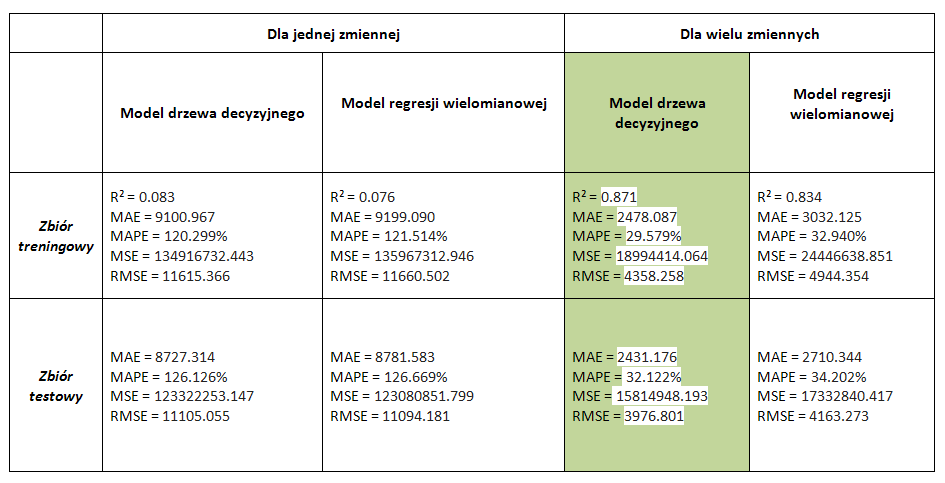

Jak widać powyżej najbardziej korzystne wyniki oceny otrzymał model drzewa decyzyjnego przy użyciu kilku zmiennych.

#Wizualizacyjne ocena modelu

W tej części postanowiono przeanalizować za pomocą wizualizacji model, który w przeprowadzonych analizach dał najbardziej korzystne wyniki -> model drzewa decyzyjnego przy zastosowaniu wielu zmiennych.

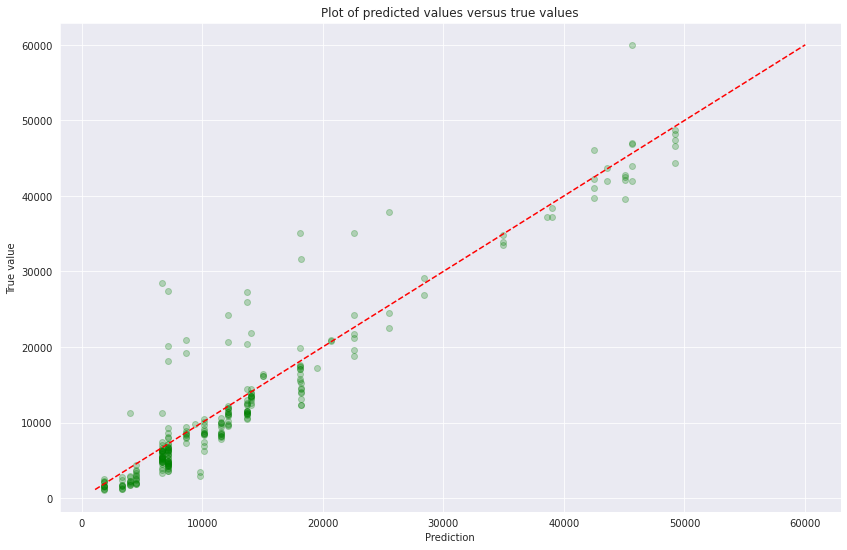

In [51]:
# Porównanie wartości prawdziwej z predykcją
plt.figure(figsize=(14,9))
plt.scatter(x = y_predict_test_model_tree, y = y_test, alpha=0.25, color='green')

xmin, xmax = y_test.min(), y_test.max()
x_line = np.linspace(xmin, xmax, 10)
y_line = x_line

# Oczekiwana linia trendu
plt.plot(x_line, y_line, 'r--')

plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title('Plot of predicted values versus true values')
plt.show()

Przerywana linia obrazuje jakie wartości przyjmie nasz model natomiast zielone punkty są rzeczywistymi wartościami, które wystąpiły na zbiorze testowym. W wizualizacji wykorzystano jedynie zbiór testowy, ponieważ zakładamy, że jest to grupa danych dla których wartości nie znamy, model powinnien je przewidzieć (zbiór nie brał udziału w uczeniu modelu)

Na powyższym wykresie możemy zobserwować, że wartości prawdziwe nieco różnią się od tych które przewiduje nasz "dobry" model.

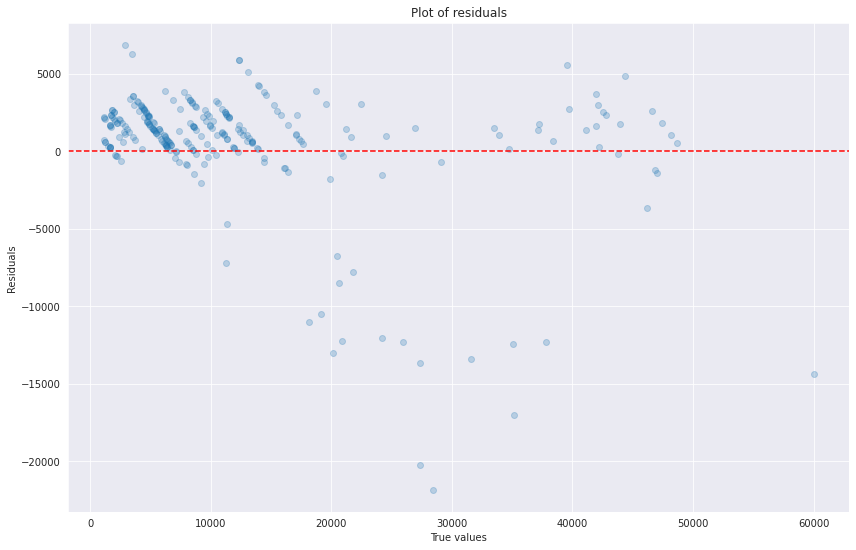

In [53]:
# Wykres reszt
plt.figure(figsize=(14,9))
errors = y_predict_test_model_tree - y_test
plt.scatter(x = y_test, y=errors, alpha = 0.25)
plt.axhline(0,color = 'red', linestyle='--')
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.title('Plot of residuals')
plt.show()

Powyższy wykres powinien przypominać chmurę, jednak można zaobserwować tu niewielką zależność. Może to oznaczać, że nie wyjaśniono w pełni zmienności, więc model należy jeszcze dopracować.



518.0956431248724


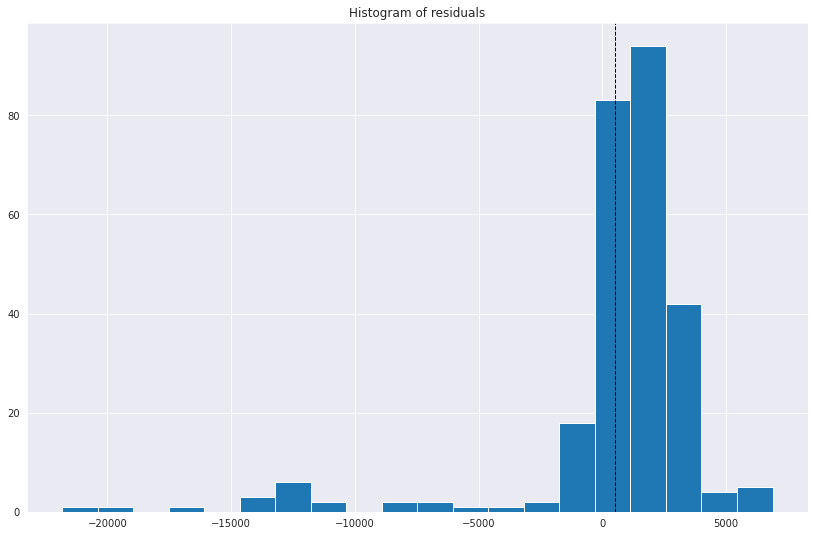

In [55]:
#Histogram reszt

plt.figure(figsize=(14,9))
print(errors.mean())
plt.hist(errors, bins=20)
plt.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=1)
plt.title('Histogram of residuals')

plt.show()

Na hisogramie reszt najepiej można zobserwować, że model jest obciążony. Średnio model przeszacowuje, ponieważ średni błąd jest >0. Kolejny problem wynika też z nie w pełni wyjaśnionej wariancji co widoczne jest w skońności wykresu.

Na podstawie powyższych wykresów możemy ocenić, że model nie wyjaśnia do końca wszystkich zmiennych.